# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [ ]:
# Run this cell to download and unzip images if not already on local drive
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip dogImages.zip
!unzip lfw.zip

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


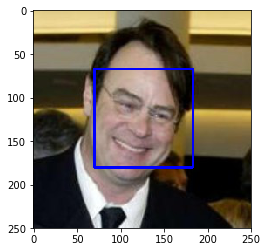

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# given an array of image filepaths (img_files) and a detector function,
# returns number of images in img_files containing detected object       
def count_detected_files(img_files, detector_fn):
    num_detected = 0
    for image in img_files:
        num_detected += detector_fn(image)
    return num_detected

human_files_detected = count_detected_files(human_files_short, face_detector)
dog_files_detected = count_detected_files(dog_files_short, face_detector)
print(f'% detected human faces in human_files_short: {human_files_detected}')
print(f'% detected human faces in dog_files_short: {dog_files_detected}')

% detected human faces in human_files_short: 98
% detected human faces in dog_files_short: 17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

# Note: my code and commentary can be found below in the section 
# titled "Testing Alternative Face Detectors"

### Testing Alternative Face Detectors
Here, we'll test a few alternative face detectors on the first 100 images from `human_files` and `dog_files`. Let's see if we can find one that outperforms the OpenCV detector.

#### **Face Detector from face_recognition/dlib**
We'll try using the face_recognition face detector from [dlib](https://github.com/ageitgey/face_recognition#face-recognition).
Note: this requires installation of the dlib and face_recognition libraries into your local environment. We create a new face detector function `face_detector_dlib` which performs the same function as our original `face_detector` above, using dlib's pre-trained algorithm instead of OpenCV's.

In [5]:
!pip install face_recognition

    100% |████████████████████████████████| 100.2MB 451kB/s eta 0:00:01
    100% |████████████████████████████████| 3.2MB 10.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for face-recognition-models ... done
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
  Running setup.py bdist_wheel for dlib ... done
  Stored in directory: /root/.cache/pip/wheels/96/ac/11/8aadec62cb4fb5b264a9b1b042caf415de9a75f5e165d79a51
Successfully built face-recognition-models dlib


In [6]:
import face_recognition

# returns "True" if face is detected in image stored at img_path
# uses face_recognition library from dlib
def face_detector_dlib(img_path):
    img = face_recognition.load_image_file(img_path)
    faces = face_recognition.face_locations(img)
    return len(faces) > 0

# test performance of face_detector_dlib function on human_files_short
# and dog_files_short
human_files_detected = count_detected_files(human_files_short, face_detector_dlib)
dog_files_detected = count_detected_files(dog_files_short, face_detector_dlib)
print(f'% detected human faces in human_files_short: {human_files_detected}')
print(f'% detected human faces in dog_files_short: {dog_files_detected}')

% detected human faces in human_files_short: 100
% detected human faces in dog_files_short: 8


Compared to the OpenCV algorithm, we can see that this algorithm detects more human faces in `human_files_short`, and fewer human faces in `dog_files_short`. This is an improvement!  

face_recognition defaults to a non deep learning based model. However, by adding the parameter `model='cnn'` we can access a more accurate deep learning based face detection model. Note that this only works if GPU acceleration is enabled. Let's test that next.

In [7]:
# returns "True" if face is detected in image stored at img_path
# uses face_recognition library from dlib, with CNN's activated
def face_detector_dlib_cnn(img_path):
    img = face_recognition.load_image_file(img_path)
    faces = face_recognition.face_locations(img, model='cnn')
    return len(faces) > 0

# test performance of face_detector_dlib_cnn
human_files_detected = count_detected_files(human_files_short, face_detector_dlib_cnn)
dog_files_detected = count_detected_files(dog_files_short, face_detector_dlib_cnn)
print(f'% detected human faces in human_files_short: {human_files_detected}')
print(f'% detected human faces in dog_files_short: {dog_files_detected}')

% detected human faces in human_files_short: 100
% detected human faces in dog_files_short: 6


Yet another improvement! The algorithm detected all the faces in `human_files_short` and reduced the number of human faces detected in `dog_files_short`.

#### **MTCNN Face Detector from facenet-pytorch**
Next, let's try using the face detector from [facenet-pytorch](https://github.com/timesler/facenet-pytorch), which is an implementation of a MTCNN (multi-task cascaded CNN).
Note: this requires installation of the facenet-pytorch library into your local environment. We create a new face detector function `face_detector_mtcnn` which utilizes this MTCNN detector

In [63]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 8.8MB/s 


In [66]:
import torch
from facenet_pytorch import MTCNN

# returns "True" if face is detected in image stored at img_path
# uses MTCNN face detector from facenet-pytorch
def face_detector_mtcnn(img_path):
    # initialize face detector
    if torch.cuda.is_available():
        mtcnn = MTCNN(select_largest='FALSE', device='cuda')
    else:
        mtcnn = MTCNN(select_largest='FALSE')

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = mtcnn(img)
    return faces is not None
    
# test performance of face_detector_mtcnn
human_files_detected = count_detected_files(human_files_short, face_detector_mtcnn)
dog_files_detected = count_detected_files(dog_files_short, face_detector_mtcnn)
print(f'% detected human faces in human_files_short: {human_files_detected}')
print(f'% detected human faces in dog_files_short: {dog_files_detected}')

% detected human faces in human_files_short: 100
% detected human faces in dog_files_short: 24


This MTCNN detector picks up more human faces in `dog_files_short` than the face_recognition algorithms do. Of the face detector algorithms we've tested, face_recognition with cnn/deep-learning performs best on `human_files_short` and `dog_files_short`

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 102164106.16it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [9]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    img = Image.open(img_path).convert('RGB')

    # images must be 224x224 and normalized to specific values for VGG-16
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                                         (0.229, 0.224, 0.225))])
    
    # discard alpha channel if applicable and add dimension for batchsize of 1
    img = transform(img)[:3,:,:].unsqueeze(0)

    # move img to GPU if CUDA is available
    if use_cuda:
        img = img.cuda()

    ## Return the *index* of the predicted class for that image
    logits = VGG16(img)
    _, class_index = torch.max(logits, dim=1)
    return class_index.item()

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    class_index = VGG16_predict(img_path)
    return class_index >= 151 and class_index <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# test performance of dog_detector
human_files_detected = count_detected_files(human_files_short, dog_detector)
dog_files_detected = count_detected_files(dog_files_short, dog_detector)
print(f'% detected dogs in human_files_short: {human_files_detected}')
print(f'% detected dogs in dog_files_short: {dog_files_detected}')

% detected dogs in human_files_short: 0
% detected dogs in dog_files_short: 100


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

### Testing Other Pre-trained Models as Dog Detectors
Let's test the performance of another pre-trained PyTorch model. To start, we should generalize the `VGG16_predict` function above to work with any pre-trained PyTorch model.

In [12]:
def ImageNet_predict(img_path, model):
    '''
    Use pre-trained model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        model: pre-trained PyTorch model (e.g. vgg16, resnet50, etc.)
        
    Returns:
        Index corresponding to model's prediction
    '''
    
    # Load image from the given img_path
    img = Image.open(img_path).convert('RGB')

    # images must be 224x224 and normalized to specific values for PyTorch's
    # pre-trained models
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                                         (0.229, 0.224, 0.225))])

    # discard alpha channel if applicable and add dimension for batchsize of 1
    img = transform(img)[:3,:,:].unsqueeze(0)

    # move img to GPU if CUDA is available
    if use_cuda:
        img = img.cuda()

    # Return the *index* of the predicted class for that image
    logits = model(img)
    _, class_index = torch.max(logits, dim=1)
    return class_index.item()

#### **Testing AlexNet**

In [13]:
# load pre-trained model, move to GPU if cuda is available
Alexnet = models.alexnet(pretrained=True)
if use_cuda:
    Alexnet = Alexnet.cuda()

# returns "True" if a dog is detected in the image stored at img_path
# uses AlexNet
def dog_detector_alexnet(img_path):
    class_index = ImageNet_predict(img_path, Alexnet)
    return class_index >= 151 and class_index <= 268

# test performance of dog_detector_alexnet
human_files_detected = count_detected_files(human_files_short, dog_detector_alexnet)
dog_files_detected = count_detected_files(dog_files_short, dog_detector_alexnet)
print(f'% detected dogs in human_files_short: {human_files_detected}')
print(f'% detected dogs in dog_files_short: {dog_files_detected}')

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:02<00:00, 81645515.05it/s]


% detected dogs in human_files_short: 2
% detected dogs in dog_files_short: 99


AlexNet performs quite well, but it looks like VGG-16 slightly outperforms. 
#### **Testing SqueezeNet**

In [14]:
# load pre-trained model, move to GPU if cuda is available
Squeezenet = models.squeezenet1_0(pretrained=True)
if use_cuda:
    Squeezenet = Squeezenet.cuda()

# returns "True" if a dog is detected in the image stored at img_path
# uses SqueezeNet
def dog_detector_squeezenet(img_path):
    class_index = ImageNet_predict(img_path, Squeezenet)
    return class_index >= 151 and class_index <= 268

# test performance of dog_detector_squeezenet
human_files_detected = count_detected_files(human_files_short, dog_detector_squeezenet)
dog_files_detected = count_detected_files(dog_files_short, dog_detector_squeezenet)
print(f'% detected dogs in human_files_short: {human_files_detected}')
print(f'% detected dogs in dog_files_short: {dog_files_detected}')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.torch/models/squeezenet1_0-a815701f.pth
100%|██████████| 5017600/5017600 [00:00<00:00, 23803579.53it/s]


% detected dogs in human_files_short: 3
% detected dogs in dog_files_short: 99


SqueezeNet seems to detect more dog faces in `human_files_short` compared to AlexNet and VGG16. VGG16 has the best performance of the three models we tested 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [15]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# image size (for square image) to be input into model
input_size = 224

# transforms for training dataset, with data augmentation
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.Resize(300),
                                       transforms.RandomResizedCrop(input_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406),
                                                            (0.229, 0.224, 0.225))])

# transforms for test and validation datasets, no data augmentation
test_transforms = transforms.Compose([transforms.Resize(input_size + 32),
                                      transforms.CenterCrop(input_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# create training, validation, and test datasets with ImageFolder
root = '/data/dog_images'
train_data = datasets.ImageFolder(root + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(root + '/valid', transform=test_transforms)
test_data = datasets.ImageFolder(root + '/test', transform=test_transforms)

# create dataloaders for training, validation, and test sets
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# create dictionary of dataloaders
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [16]:
# helper function
def show_img(img_tensor):
    '''takes in an image in tensor form and transforms it so that it can be
    displayed
    '''

    # convert to numpy, rearrange dimensions for matplotlib
    img = img_tensor.numpy().transpose((1, 2, 0))
    # un-normalize 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.show()

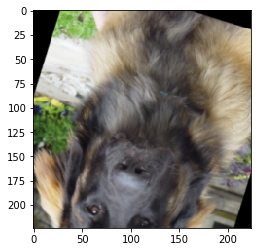

In [27]:
# visualize sample image from train_data
images, labels = iter(train_loader).next()
show_img(images[0])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:  
I chose an input tensor with image dimensions 224x224, as this is the standard input size for PyTorch's pre-trained models. 224 is divisible by a high multiple of 2 (32), allowing for a good number of maxpooling dimension reduction layers. To avoid stretching the image, I resized the image to a size slightly larger than the target input size, then cropped a 224x224 square region.

This algorithm is meant to work on real world user supplied images, which could be flipped, not centered, slightly angled, etc. To train a robust model which can handle these real world variations, I thought it best to augment the training dataset with horizontal and vertical flips, rotations, and modest RandomResizedCrop (resizing the image to be closer to target size before cropping). I chose the data augmentation transforms based on variations most likely to occur in user supplied images.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super().__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(p=0.25)

        # input nodes to fc1 are calculated based on flattening the output of the
        # convolutional feature detector
        self.fc1 = nn.Linear(128*28*28, 256)
        # there are 133 breeds in the dataset, so we need 133 output nodes
        self.output = nn.Linear(256, 133)

    def forward(self, x):
        ## Define forward behavior
        # convolutional feature detector
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)

        # flatten output of feature detector for fully connected layers
        x = x.view(x.shape[0], -1)

        # fully connected classifier
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.output(x), dim=1)

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__   

In general, I followed the principle of increasing the depth of the feature maps by powers of 2 as we progress through the model. I drew inspiration from VGG and other models which stack multiple convolutional layers together before a pooling layer. I initially stacked two convolutional layers before every maxpool layer, similar to the earlier stacks in the VGG model, increasing the depth by a power of 2 in each stack.

I started out with a relatively simple structure for the sake of an initial test run. The feature detector consisted of 3 stacks, each containing 2 convolutional layers and one maxpooling layer. I chose to use 3x3 kernels with stride and padding of 1, to avoid reducing the size of the feature maps during convolution. This was followed by two fully connected layers making up the classifier. Following industry standard, I used ReLu as the activation function after each convolutional layer as well as the hidden fully connected layers. I chose to use a log_softmax activation function on the output layer, as opposed to raw logits, so that I could easily obtain predicted class probabilities if needed. I omitted Dropout from my initial structure to test baseline performance.

After training with this initial structure, I added Dropout (p=0.25) after each maxpool layer and after the hidden fully connected layer. This resulted in a boost in accuracy.

Noticing the model took a while to train, I tested a simpler structure to see if we could still attain comparable accuracy with fewer convolutional layers. I adjusted the model to contain only one convolutional layer per stack. There did not seem to be a noticeable decrease in accuracy.

Thus, my final model architecture consists of three stacks, each containing one convolutional layer, ReLu activation, maxpool, then Dropout (p=0.25). The first convolutional layer has depth of 32, and each subsequent layer increases depth by a factor of 2. I kept the same two fully connected linear layers from my initial run, 256 hidden units followed by 133 output units, one for each dog breed class. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [29]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [30]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear gradients before each forward pass
            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################    
        # validate the model #
        ######################
        with torch.no_grad():
            model.eval()
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                output = model(data)
                loss = criterion(output, target)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('validation loss decreased, saving model')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(40, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.876665 	Validation Loss: 4.841347
validation loss decreased, saving model
Epoch: 2 	Training Loss: 4.780977 	Validation Loss: 4.664385
validation loss decreased, saving model
Epoch: 3 	Training Loss: 4.686862 	Validation Loss: 4.602587
validation loss decreased, saving model
Epoch: 4 	Training Loss: 4.628593 	Validation Loss: 4.548619
validation loss decreased, saving model
Epoch: 5 	Training Loss: 4.591722 	Validation Loss: 4.540628
validation loss decreased, saving model
Epoch: 6 	Training Loss: 4.552777 	Validation Loss: 4.528020
validation loss decreased, saving model
Epoch: 7 	Training Loss: 4.541504 	Validation Loss: 4.480077
validation loss decreased, saving model
Epoch: 8 	Training Loss: 4.501096 	Validation Loss: 4.407411
validation loss decreased, saving model
Epoch: 9 	Training Loss: 4.483840 	Validation Loss: 4.365331
validation loss decreased, saving model
Epoch: 10 	Training Loss: 4.455938 	Validation Loss: 4.307927
validation loss decreased, sa

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [31]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.589590


Test Accuracy: 13% (109/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [32]:
## TODO: Specify data loaders
# use same data loaders from previous step, where we built a CNN from scratch
loaders_transfer = loaders_scratch

# create dictionary of datasets
data_transfer = {'train': train_data, 'valid': valid_data, 'test': test_data}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [33]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

# use pre-trained VGG16 network
model_transfer = models.vgg16(pretrained=True)

# freeze parameters of pre-trained feature detector
for param in model_transfer.features.parameters():
    param.requires_grad = False

# replace last layer of pre-trained classifier with new layer built for dog
# breed task
model_transfer.classifier[6] = nn.Linear(4096, 133)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [34]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
In the dog detector section, we saw that VGG16 outperformed AlexNet and SqueezeNet as a dog detector, correctly detecting dogs in all 100 images in `dog_files_short` while showing very few or no false positives in `human_files_short`. Given its strong performance on the dog detection task, I started with VGG16 as the pre-trained model used in this  transfer learning exercise.

We have a relatively small dataset (8,000+ images in dogImages/train) which is similar in nature to the training dataset for the pre-trained model. Additionally, the classes in our classification problem (dog breeds) are a subset of the classes in the training dataset (ImageNet categories). Thus we should not need to make many changes to the pre-trained model's architecture, other than changing the number of output units to reflect the task at hand. 

We will keep the pre-trained feature detector as is. We set `requires_grad` to false for feature detector parameters so that they will not change during training. For the fully connected classifier, we keep the existing architecture except for the final layer, which is replaced so that the number of output units corresponds to the number of dog breeds in our classification task. We then train the entire classifier. 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [35]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [36]:
# train the model
model_transfer = train(30, loaders_transfer, model_transfer, 
                       optimizer_transfer, criterion_transfer, use_cuda,
                       'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.847144 	Validation Loss: 0.824879
validation loss decreased, saving model
Epoch: 2 	Training Loss: 1.865077 	Validation Loss: 0.615438
validation loss decreased, saving model
Epoch: 3 	Training Loss: 1.726238 	Validation Loss: 0.558036
validation loss decreased, saving model
Epoch: 4 	Training Loss: 1.580538 	Validation Loss: 0.528873
validation loss decreased, saving model
Epoch: 5 	Training Loss: 1.542303 	Validation Loss: 0.531876
Epoch: 6 	Training Loss: 1.459208 	Validation Loss: 0.493165
validation loss decreased, saving model
Epoch: 7 	Training Loss: 1.434144 	Validation Loss: 0.495009
Epoch: 8 	Training Loss: 1.381690 	Validation Loss: 0.464402
validation loss decreased, saving model
Epoch: 9 	Training Loss: 1.376541 	Validation Loss: 0.465204
Epoch: 10 	Training Loss: 1.314982 	Validation Loss: 0.469025
Epoch: 11 	Training Loss: 1.309317 	Validation Loss: 0.472418
Epoch: 12 	Training Loss: 1.274370 	Validation Loss: 0.453996
validation loss decreased

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [37]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.480440


Test Accuracy: 86% (720/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [38]:
# helper function
def preprocess_img(img_path):
    """Load and pre-process the image located at img_path so that it can be
    passed into model_transfer
    """

    # load image
    img = Image.open(img_path).convert('RGB')
    # transforms to resize, convert to tensor, and normalize
    img = test_transforms(img)
    # discard alpha channel if applicable and add dimension for batchsize of 1
    img = img[:3,:,:].unsqueeze(0)

    return img

In [39]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image at img_path and return the predicted dog breed
    
    # load and pre-process the image to be input into model
    img = preprocess_img(img_path)

    # move image to GPU if CUDA is available
    if use_cuda:
        img = img.cuda()

    # run through model to obtain predicted breed
    output = model_transfer(img)
    _, class_idx = output.max(dim=1)

    return class_names[class_idx.item()]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [80]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither

    # if human face is detected in image at img_path
    if face_detector_dlib_cnn(img_path):
        predicted_breed = predict_breed_transfer(img_path)
        print(f'Hello human! You look like a {predicted_breed}')
        show_img(preprocess_img(img_path).squeeze())

    # if dog is detected in image at img_path
    elif dog_detector(img_path):
        predicted_breed = predict_breed_transfer(img_path)
        print(f'Hello dog! Your predicted breed is {predicted_breed}')
        show_img(preprocess_img(img_path).squeeze())

    # if neither human face nor dog detected in image at img_path, throw error
    else:
        print("Error: this app is only designed for images of humans and dogs")
        show_img(preprocess_img(img_path).squeeze())

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

* The algorithm is designed to return the most likely breed (selecting the class with the highest score). One improvement would be to take into account the possibility of mixed breeds. For example, if probability for a given breed is less than a certain amount, or if two or more top classes have scores within a certain range of each other, return the top few breeds instead.
* The dog breed classifier model obtained a test accuracy of 86% after training for 30 epochs. While this produced high enough accuracy to pass the 60% requirement for this project, we could continue to train for additional epochs or adjust learning rate to see whether validation loss truly has reached its minimum.
* While our face_recognition_dlib_cnn face detector achieved improved results compared to the OpenCV face detector, it still picked up some false positives in `dog_files_short`. We could potentially improve the algorithm by finding a face detector with a lower false positive rate.
* We only tested our face and dog detection functions on images of humans and dogs. However, we did not test on images of other animals such as cats. It's possible our functions could mistakenly pick up false positives for humans or dogs in images of other animals. Expanding the testing dataset and choosing the detector function with the best performance across a wider dataset could yield improved results.  

After testing on a few "real world" images, we can make the following observations:
* The algorithm successfully classifies pictures of cats as neither dog nor human and throws the error message
* The algorithm performed well on the beagle and pomeranian pictures, which were taken from the internet based on a Google search for "beagle" and "pomeranian" respectively. These pictures are not representative of "real world" pictures and are likely highly representative of their breed given the search results
* The algorithm did not perform as well on the "real world" images of dogs, guessing 3 different breeds on 3 different pictures of the same dog. The dog in question is a mixed breed, which makes the problem harder, however, neither of its mixes were predicted by the algorithm. One possible improvement would be to tweak data augmentation so that the training dataset better represents "real world" images

Hello human! You look like a Chihuahua


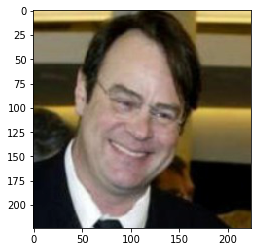

Hello human! You look like a Lowchen


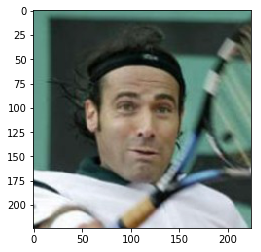

Hello human! You look like a Cocker spaniel


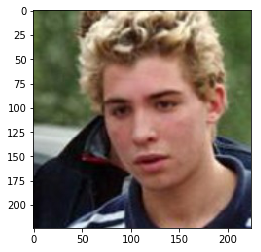

Hello dog! Your predicted breed is Mastiff


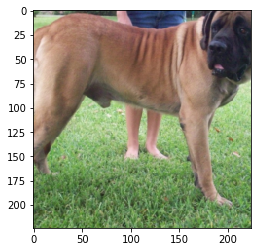

Hello dog! Your predicted breed is Mastiff


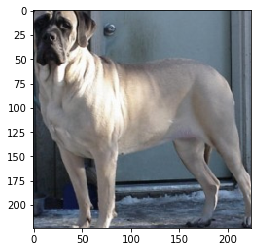

Hello dog! Your predicted breed is Mastiff


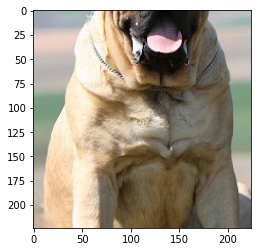

In [81]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

Hello human! You look like a Bearded collie


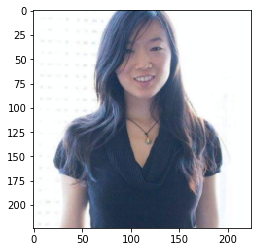

Hello dog! Your predicted breed is Portuguese water dog


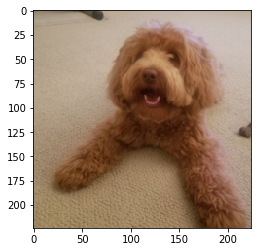

Hello dog! Your predicted breed is Cocker spaniel


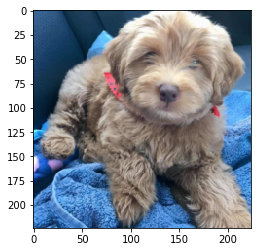

Hello human! You look like a Poodle


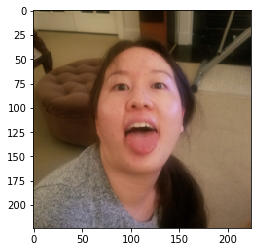

Hello dog! Your predicted breed is Havanese


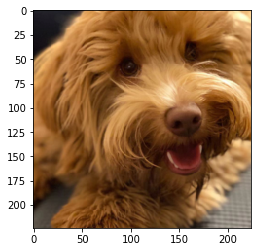

Error: this app is only designed for images of humans and dogs


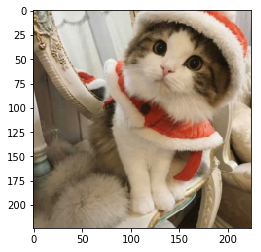

Hello human! You look like a Maltese


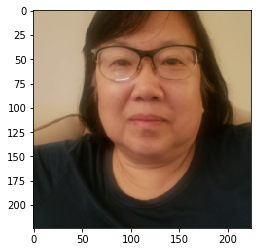

Hello dog! Your predicted breed is Beagle


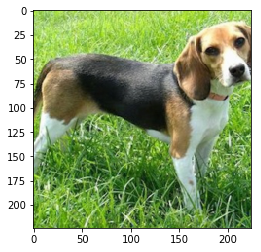

Hello dog! Your predicted breed is Pomeranian


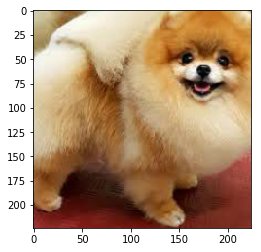

Error: this app is only designed for images of humans and dogs


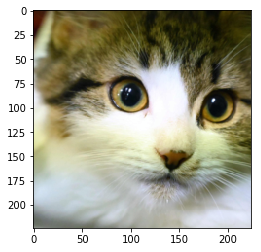

In [82]:
# test algorithm on images from local computer
root = '/home/workspace/dog_project/test_images'
test_files = np.array(glob(root + '/*'))

for file in np.hstack(test_files):
    run_app(file)